# Technical notebook

### Lending Club Data Set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from loan_helper import data_cleaning
from loan_helper import data_converting, column_description


#SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

In [2]:
!ls -lath LendingClub

total 1406288
drwxr-xr-x  22 Daniel  staff   704B Oct 24 12:05 ..
-rw-r--r--   1 Daniel  staff   6.0K Oct 22 17:37 .DS_Store
drwxr-xr-x   8 Daniel  staff   256B Oct 22 17:37 .
-rw-r--r--@  1 Daniel  staff    41M Oct 22 17:36 LoanStats3c_securev1.csv.zip
-rw-r--r--@  1 Daniel  staff    73M Oct 21 11:03 LoanStats3d_securev1.csv.zip
-rw-r--r--   1 Daniel  staff    23K Oct 21 11:03 LCDataDictionary.xlsx
-rwxr-xr-x@  1 Daniel  staff   357M Oct  1 06:44 LoanStats3d_securev1.csv
-rwxr-xr-x@  1 Daniel  staff   201M Oct  1 06:42 LoanStats3c_securev1.csv


- LendingClub data source:

https://www.lendingclub.com/info/download-data.action

In [3]:
#reading excel
description = pd.read_excel('LendingClub/LCDataDictionary.xlsx')

In [4]:
#reading Lending Club loan data from 2014
# data_lc = pd.read_csv('LendingClub/LoanStats3c_securev1.csv', low_memory=False, header=1)

In [5]:
#read in Lending Club loan data from zip file
from zipfile import ZipFile
zip_file = ZipFile('LendingClub/LoanStats3c_securev1.csv.zip')
data_lc = pd.read_csv(zip_file.open('LoanStats3c_securev1.csv'), low_memory=False, header=1)

In [6]:
data_lc.loan_amnt.isna().sum()

2

In [7]:
#removed two rows with full NAN values
data_lc = data_lc.loc[data_lc.loan_amnt.notnull()]
data_lc.shape

(235629, 150)

## Feature selection and feature engineering

### Understanding the columns

In order to understand the columns we created a dataframe with column names, two examples, datatype, number of missing values, and the long description. The dataframe was exported to excel to make decision on columns. The result is stored in col_selection.xlsx.

In [8]:
desc = column_description(data_lc, description)

In [9]:
pd.set_option('display.max_colwidth', -1) #this allows us to see the very long description, if exceeds 50 char
desc.head(2)

,col_name,exmp1,exmp2,dtype,Description,nan_counts
0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0
1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,235629


In [10]:
desc.to_excel('col_desc_2014.xlsx')

### First round feauture selection

Originally the dataset contained 150 columns. When we were reducing the features in order to avoid the overfitting the model we selected features according to the following:

- Discarded columns that contained payment or collection information (47 columns)
- Discarded columns that contained information that were not available at the time of credit application
- Discarded features that require too much data processing (typically free input i.e. emp_title)
- Discarded redundant features (subgrade - grade, title - purpose)
- Discarded feauters that contain too much NAN values (mnths_since_last_delinq, mths_since_recent_bc_dlq, mths_since_recent_revol_delinq)

In [11]:
col_selection = pd.read_excel('col_selection_2014.xlsx')

In [12]:
col_selection.head(3)

,Unnamed: 0,col_name,exmp1,exmp2,dtype,Description,nan_counts,Decision,Cause
0,0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0,remove,irrelevant
1,1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,235629,remove,irrelevant
2,2,loan_amnt,7650,23325,float64,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",0,keep,NaN


In [13]:
selected_col = col_selection.loc[col_selection.Decision == 'keep', 'col_name'].to_list()
len(selected_col)

59

In [14]:
dataset = data_lc.loc[:, selected_col]

In [15]:
dataset.shape

(235629, 59)

### Converting data types

- emp_length column was converted to numeric
- earliest credit line: convert date to numeric (years)
- revol_util (revolving utilization) was converted to numeric
- creating regions from state, state column was removed
- reduce categories of loan purpose
- filled nan values with 0 where in for cases (mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,
emp_length, mo_sin_old_il_acct)

In [16]:
dataset = data_converting(dataset)

In [17]:
# dataset.info()

### Determing the target feature

In [18]:
df_term = pd.DataFrame(dataset.loan_status.value_counts())
df_term

,loan_status
Fully Paid,189555
Charged Off,41609
Current,4215
Late (31-120 days),144
In Grace Period,76
Late (16-30 days),30


#### Meaning of the categories
<b>Fully paid:</b> Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

<b>Current:</b> Loan is up to date on all outstanding payments. 

<b>In Grace Period:</b> Loan is past due but within the 15-day grace period. 

<b>Late (16-30):</b> Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

<b>Late (31-120):</b> Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

<b>Default:</b> Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”.

<b>Charged Off:</b> Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

Sosurce: https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

In [19]:
pd.crosstab(columns=dataset['loan_status'], index=dataset['term'],)

loan_status,Charged Off,Current,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
term,,,,,,
36 months,22315,0,140255,0,0,0
60 months,19294,4215,49300,76,30,144


We decided to ignore the 'gray' categories, where there might chance to the recovery of the loan. The 'Current' category contains the 60 months term loans, removing them would panalize the long term loans by increasing the default rate within this category. 

In [20]:
#Select default categories:
dataset.loc[dataset.loan_status == 'Fully Paid', 'default'] = 0
dataset.loc[dataset.loan_status == 'Charged Off', 'default'] = 1
dataset.loc[dataset.loan_status == 'Current', 'default'] = 0
#dropped the rows where the loan status was different
dataset = dataset.loc[dataset.default.notnull()]

In [21]:
#remove loan_status, default replace it
dataset = dataset.drop(columns='loan_status')

In [22]:
dataset = dataset.reset_index()
dataset = dataset.drop(columns='index')

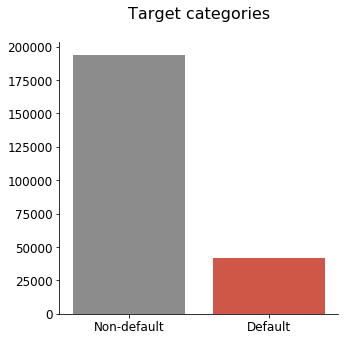

In [23]:
my_palette = ["#8c8c8c", "#e54632"]

fig1 = plt.figure(figsize=(5,5))
sns.countplot(x = 'default', data=dataset, palette=my_palette, )
ax = plt.gca()
plt.title('Target categories\n', fontsize=16)
ax.set_xticklabels(['Non-default', 'Default'])
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig1.savefig('Target_var');

In [24]:
# dataset.head()

In [25]:
x_feats = dataset.columns.to_list()
x_feats.remove('default')

### Multicollinearity examination

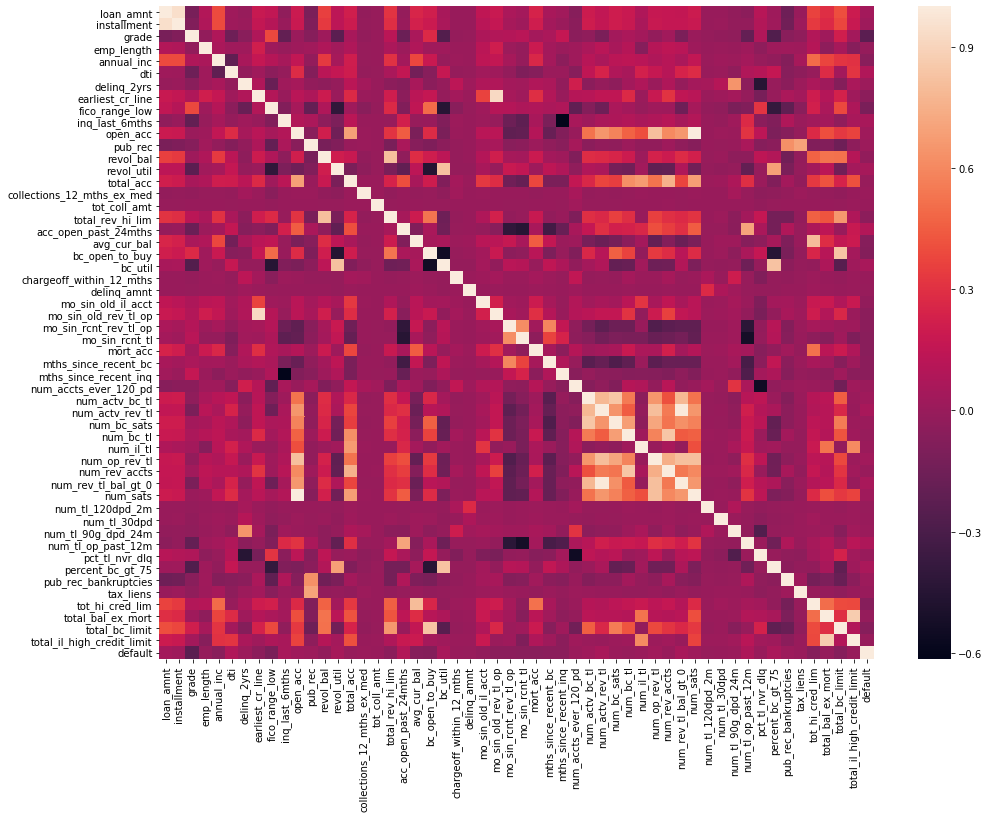

In [26]:
corr = dataset.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr);
# corr

In [27]:
corr_df = []
for i in range(corr.shape[1]):
    for j in range(i+1, corr.shape[1]):
        if corr.iat[i,j]>0.8:
            corr_df.append([corr.index[i], corr.columns[j], corr.iat[i,j]])
corr_df = pd.DataFrame(corr_df, columns = ['col_name1','col_name2', 'r_square'])

In [28]:
corr_df

,col_name1,col_name2,r_square
0,loan_amnt,installment,0.947946
1,earliest_cr_line,mo_sin_old_rev_tl_op,0.923295
2,open_acc,num_op_rev_tl,0.812278
3,open_acc,num_sats,0.998641
4,revol_bal,total_rev_hi_lim,0.816803
5,revol_util,bc_util,0.818250
6,avg_cur_bal,tot_hi_cred_lim,0.803073
7,bc_open_to_buy,total_bc_limit,0.833603
8,bc_util,percent_bc_gt_75,0.828988
9,num_actv_bc_tl,num_bc_sats,0.837523


In [29]:
remove_col = ['installment', 'mo_sin_old_rev_tl_op', 'num_sats', 'revol_bal', 'bc_util', 'num_bc_tl',
             'avg_cur_bal', 'total_bc_limit', 'num_actv_bc_tl', 'num_rev_tl_bal_gt_0', 'total_bal_ex_mort']

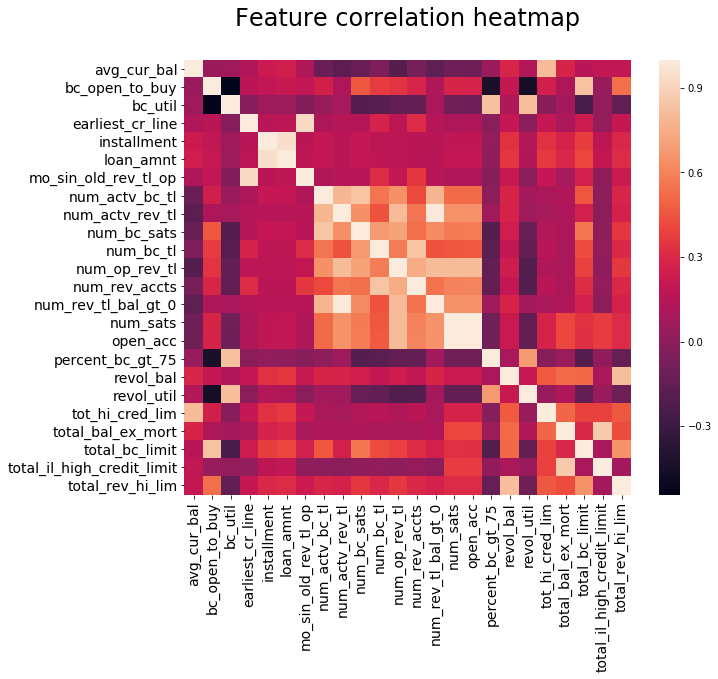

In [30]:
corr_columns = list(set(corr_df.col_name1.unique()) | set(corr_df.col_name2.unique()))
corr_columns.sort()
corr2 = dataset.loc[:,corr_columns].corr()
fig2 = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=14)
plt.title('Feature correlation heatmap\n', fontsize = 24)
sns.heatmap(corr2)
fig2.savefig('Feature_corr2');

In [31]:
[x_feats.remove(col) for col in remove_col]

[None, None, None, None, None, None, None, None, None, None, None]

In [32]:
len(x_feats)

47

In [33]:
# x_feats

## Preparing dataset for modeling

In [34]:
X = pd.get_dummies(dataset[x_feats], drop_first=True)

In [35]:
y = dataset.default

In [36]:
y.value_counts()

0.0    193770
1.0    41609 
Name: default, dtype: int64

In [80]:
X.grade.value_counts()

5    66505
6    61909
4    42916
7    36105
3    20055
2    6208 
1    1681 
Name: grade, dtype: int64

In [81]:
X.columns

Index(['loan_amnt', 'grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_bc_sats', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_il_high_credit_limit', 'term_ 60 months',
       'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verifi

In [37]:
X.head()

,loan_amnt,grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,fico_range_low,inq_last_6mths,open_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,region_NE,region_SE,region_SW,region_W
0,10400.0,7,8.0,58000.0,14.92,0.0,26,710.0,2.0,17.0,...,0,0,0,0,0,0,0,0,0,1
1,15000.0,5,10.0,78000.0,12.03,0.0,21,750.0,0.0,6.0,...,0,0,0,0,0,0,0,1,0,0
2,9600.0,5,10.0,69000.0,25.81,0.0,23,680.0,0.0,12.0,...,0,0,0,0,0,0,1,0,0,0
3,12800.0,4,10.0,125000.0,8.31,1.0,15,665.0,0.0,8.0,...,0,0,0,0,0,0,0,0,0,1
4,21425.0,4,6.0,63800.0,18.49,0.0,12,685.0,0.0,10.0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
X.shape

(235379, 61)

In [39]:
# X.columns

### Train-Test Split

In [40]:
#'Stratify=y' provide us the same ratio in the target variable then it was in the original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y) #25%

In [41]:
y_train.mean()

0.1767761451051922

In [42]:
y_test.mean()

0.17676947914011387

### Further datacleaning separately for train and test


- annual_inc: in case of annual income we had to handle extreme values (there are many strategies, we were choosing truncating the extreme values to the value of the 99 quantile)
- imputing median values in place of missing values

In [43]:
imp = SimpleImputer(strategy='median', copy=True, fill_value=None)
imp.fit(X_train)  

X_train_imp = imp.transform(X_train)      
X_test_imp = imp.transform(X_test)

In [44]:
income_trunc = X_train.annual_inc.quantile(q=0.99)
income_trunc

b_train = X_train_imp > income_trunc
b_test = X_test_imp > income_trunc

X_train_imp[b_train] = income_trunc
X_test_imp[b_test] = income_trunc

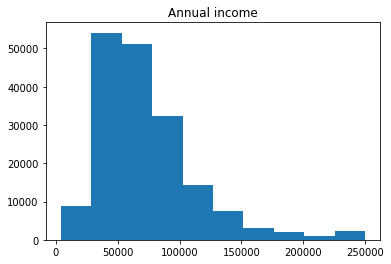

In [45]:
plt.hist(X_train_imp[:,3])
plt.title('Annual income');

### Scaling

The most standard scaling method

In [46]:
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

In [84]:
len(X_train_scaled[0])

61

In [86]:
X_train_scaled[-1]

array([-0.33879592,  0.67311744,  0.51594882, -1.03855252,  1.21250408,
       -0.38333116, -1.15787412,  1.27928771, -0.73102813, -1.07694167,
       -0.37745972,  0.09615367, -1.51521086, -0.11122404, -0.07568721,
       -0.47217497, -1.53804252, -0.08428184, -0.09189363, -0.01727499,
       -1.91420691,  0.86423055,  2.17372985, -0.85741618,  0.08831442,
        0.2194035 , -0.39776893, -0.25494698,  0.13094066, -1.03900563,
       -0.75786168, -1.02889775, -0.03000506, -0.05662942, -0.1918053 ,
       -1.25278852,  0.68131419, -1.46112183, -0.35905289, -0.14351549,
       -1.00077501, -0.35225471, -0.66834111, -1.01842108, -0.32930725,
        1.2426856 , -0.85596671, -0.63107518,  1.79693267, -1.24131457,
       -0.24273922, -0.05681458, -0.14788169, -0.1005515 , -0.07604505,
       -0.21462856, -0.0973408 , -0.54715785, -0.56651313, -0.36776661,
        1.83019888])

## Objective: Increasing predictibility of loan defaults from actual default 

### Maximize the F1 score

In [47]:
def get_metric(y_train, y_probability):
    '''
    inputs: y_train values and from the trained model the y probabilities for default
    output: maximized F1 score, cut-off and the corresponding y_hat
    '''
    y = 0
    F1_score = 0
    cut_off = 0
    for cutoff in np.linspace(0,1,101):
        y_hat = (y_probability > cutoff) * 1
        f1 = f1_score(y_train, y_hat)
        if f1> F1_score:
            F1_score = f1
            cut_off = cutoff
            y = y_hat
    
    print('Recall:', recall_score(y_train, y))
    print('Precision:', precision_score(y_train, y))
    print('F1_score:', F1_score)
    print('Cut_off:', cut_off)
    
    conf_matrix = pd.DataFrame(confusion_matrix(y_train, y),
                                    index=['actual 0', 'actual 1'],
                                    columns=['predicted 0', 'predicted 1'])
    return conf_matrix

 ## Model Selection - Logistic regression

## I. Modeling without imbalance strategy

### A. Baseline: vanilla logistic regression (w/o imbalance strategy)

In [48]:
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)

model_vanilla = logreg_vanilla.fit(X_train_scaled, y_train)
y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]
get_metric(y_train, y_probability)

Recall: 0.6367481654756946
Precision: 0.28270024185517145
F1_score: 0.39155837118338477
Cut_off: 0.18


,predicted 0,predicted 1
actual 0,94908,50419
actual 1,11336,19871


In [49]:
p, r, t = precision_recall_curve(y_train, model_vanilla.decision_function(X_train_scaled))

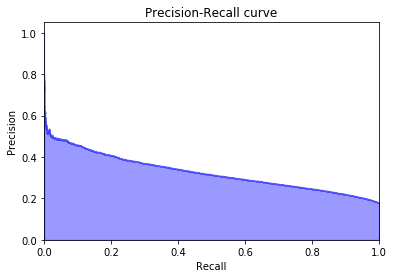

In [50]:
from inspect import signature
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(r, p, color='b', alpha=0.4, where='post')
plt.fill_between(r, p, color='b', alpha=0.4, **step_kwargs)
plt.xlabel('precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1])
plt.title('Precision-Recall curve');

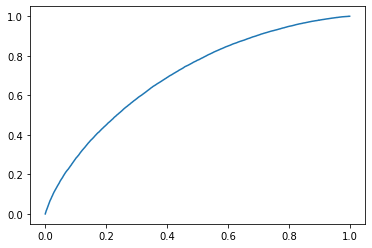

In [51]:
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_train, y_probability)
plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.show()

### B. Lasso regression with different C values (w/o imbalance strategy)

In [52]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l1 = LogisticRegression(C=C, penalty='l1',
                                   solver='liblinear',
                                   max_iter=200)
    print('-'*40,f'\nLasso regression with C = {C}')
    model_l1 = logreg_l1.fit(X_train_scaled, y_train)
    y_probability = model_l1.predict_proba(X_train_scaled)[:,1]
    print(get_metric(y_train, y_probability))


---------------------------------------- 
Lasso regression with C = 0.01
Recall: 0.6022366776684718
Precision: 0.2894412616275488
F1_score: 0.3909755666274873
Cut_off: 0.19
          predicted 0  predicted 1
actual 0  99189        46138      
actual 1  12413        18794      
---------------------------------------- 
Lasso regression with C = 0.1
Recall: 0.6371326945877528
Precision: 0.2827060613385278
F1_score: 0.39163662865134236
Cut_off: 0.18
          predicted 0  predicted 1
actual 0  94879        50448      
actual 1  11324        19883      
---------------------------------------- 
Lasso regression with C = 1
Recall: 0.6368442977537091
Precision: 0.2827388997168912
F1_score: 0.391613627854736
Cut_off: 0.18
          predicted 0  predicted 1
actual 0  94910        50417      
actual 1  11333        19874      
---------------------------------------- 
Lasso regression with C = 10
Recall: 0.636716121383023
Precision: 0.28268601508038127
F1_score: 0.3915386661674729
Cut_off: 0.18

### C. Ridge regression with different C values (w/o imbalance strategy)

In [53]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l2 = LogisticRegression(C=C, penalty='l2',
                                   solver='newton-cg',
                                   max_iter=200)
    
    print('-'*40,f'\nRidge regression with C = {C}')
    model_l2 = logreg_l2.fit(X_train_scaled, y_train)
    y_probability = model_l2.predict_proba(X_train_scaled)[:,1]
    print(get_metric(y_train, y_probability))

---------------------------------------- 
Ridge regression with C = 0.01
Recall: 0.6371647386804242
Precision: 0.28281276668373445
F1_score: 0.39174506230606315
Cut_off: 0.18
          predicted 0  predicted 1
actual 0  94903        50424      
actual 1  11323        19884      
---------------------------------------- 
Ridge regression with C = 0.1
Recall: 0.6368763418463806
Precision: 0.28273703677359696
F1_score: 0.39161789915469647
Cut_off: 0.18
          predicted 0  predicted 1
actual 0  94907        50420      
actual 1  11332        19875      
---------------------------------------- 
Ridge regression with C = 1
Recall: 0.6366840772903515
Precision: 0.2826798315501935
F1_score: 0.39152667619094533
Cut_off: 0.18
          predicted 0  predicted 1
actual 0  94908        50419      
actual 1  11338        19869      
---------------------------------------- 
Ridge regression with C = 10
Recall: 0.6367481654756946
Precision: 0.2827042638250651
F1_score: 0.3915622290533617
Cut_off:

### D. Cross-Validation (w/o imbalance strategy)

In [54]:
cv = StratifiedKFold(n_splits= 5, random_state=1000, shuffle=True)

#### Vanilla

In [55]:
lr_vanilla = LogisticRegression(C=1e9,
                                solver='newton-cg',
                                max_iter=200)


cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_scaled, y=y_train,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)

In [56]:
y_probability = cross_val_predict(lr_vanilla, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

Recall: 0.6349216521934181
Precision: 0.28180913099132415
F1_score: 0.3903582651181576
Cut_off: 0.18


,predicted 0,predicted 1
actual 0,94831,50496
actual 1,11393,19814


#### Ridge

In [57]:
l2_reg = LogisticRegression(C=1,
                            solver='newton-cg',
                            penalty='l2',
                            max_iter=200)

cv_l2 = cross_validate(estimator=l2_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [58]:
y_probability = cross_val_predict(l2_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

Recall: 0.6348896081007466
Precision: 0.2817949082634049
F1_score: 0.3903385639843573
Cut_off: 0.18


,predicted 0,predicted 1
actual 0,94830,50497
actual 1,11394,19813


#### Lasso

In [59]:
l1_reg = LogisticRegression(C=1,
                            solver='saga',
                            penalty='l1',
                            max_iter=200)
cv_l1 = cross_validate(estimator=l1_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [60]:
y_probability = cross_val_predict(l1_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

Recall: 0.6346973435447175
Precision: 0.28178171057872875
F1_score: 0.39028955950304933
Cut_off: 0.18


,predicted 0,predicted 1
actual 0,94842,50485
actual 1,11400,19807


## II. Imbalance Strategy: Random undersampling

In [61]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train) 

In [62]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train) 

In [63]:
pd.Series(y_train_rus).value_counts()

1.0    31207
0.0    31207
dtype: int64

In [64]:
pd.Series(y_train_ros).value_counts()

1.0    145327
0.0    145327
dtype: int64

### A) Baseline Vanilla (imbalance strategy: undersampling)

In [65]:
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)

model_vanilla = logreg_vanilla.fit(X_train_rus, y_train_rus)
y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]
get_metric(y_train, y_probability)

Recall: 0.6057615278623386
Precision: 0.28880910549232297
F1_score: 0.3911361238128737
Cut_off: 0.52


,predicted 0,predicted 1
actual 0,98776,46551
actual 1,12303,18904


### D. Cross-validation (imbalance strategy: undersampling)

In [66]:
#### Vanilla

In [67]:
cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_rus, y=y_train_rus,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)
y_probability = cross_val_predict(lr_vanilla, X_train_rus, y_train_rus, cv=cv, method='predict_proba')[:,1]
get_metric(y_train_rus, y_probability)

Recall: 0.8781042714775531
Precision: 0.5745225066566031
F1_score: 0.6945908952651323
Cut_off: 0.36


,predicted 0,predicted 1
actual 0,10913,20294
actual 1,3804,27403


#### Lasso

In [68]:
cv_l2 = cross_validate(estimator=l2_reg, X=X_train_rus, y=y_train_rus,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)
y_probability = cross_val_predict(l2_reg, X_train_rus, y_train_rus, cv=cv, method='predict_proba')[:,1]
get_metric(y_train_rus, y_probability)

Recall: 0.9007274009036434
Precision: 0.5652322541725316
F1_score: 0.6945896190864499
Cut_off: 0.34


,predicted 0,predicted 1
actual 0,9586,21621
actual 1,3098,28109


#### Ridge

In [69]:
cv_l2 = cross_validate(estimator=l2_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)
y_probability = cross_val_predict(l2_reg, X_train_rus, y_train_rus, cv=cv, method='predict_proba')[:,1]
get_metric(y_train_rus, y_probability)

Recall: 0.9007274009036434
Precision: 0.5652322541725316
F1_score: 0.6945896190864499
Cut_off: 0.34


,predicted 0,predicted 1
actual 0,9586,21621
actual 1,3098,28109


In [70]:
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_train_rus, y_probability)

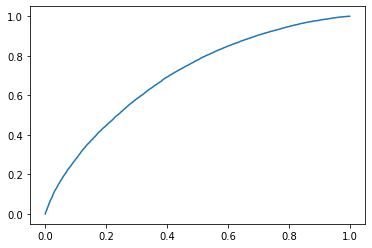

In [71]:
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_train_rus, y_probability)
plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.show()

## III. IMBALANCE STRATEGY: SMOTE

In [72]:
print(y_train.value_counts()) #Previous original class distribution
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train_scaled, y_train) 
print(pd.Series(y_train_smote).value_counts()) #Preview synthetic sample class distributi

0.0    145327
1.0    31207 
Name: default, dtype: int64
1.0    145327
0.0    145327
dtype: int64


### A) Baseline Vanilla (SMOTE)

In [73]:
# Vanilla regression
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)

model_vanilla = logreg_vanilla.fit(X_train_smote, y_train_smote)

In [74]:
y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]

get_metric(y_train, y_probability)

Recall: 0.6234178229243439
Precision: 0.28301475080736666
F1_score: 0.38929854225655086
Cut_off: 0.51


,predicted 0,predicted 1
actual 0,96040,49287
actual 1,11752,19455


#### This is our selected model, now we test on test set

In [75]:
y_probability = model_vanilla_balance.predict_proba(X_test_scaled)[:,1]

get_metric(y_test, y_probability)

NameError: name 'model_vanilla_balance' is not defined

- Visualization

In [ ]:
p_balance, r_balance, t_balance = precision_recall_curve(y_train, model_vanilla_balance.decision_function(X_train_scaled))

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(13,6))

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})


axs[0].fill_between(r, p, color='#8c8c8c', alpha=0.4, **step_kwargs)
axs[0].set(title='Imbalance Precision-Recall Curve', xlabel='Recall', ylabel='Precision', xlim=(0.0, 1), ylim=(0.0, 1.05))

axs[1].fill_between(r_balance, p_balance, color='r', alpha=0.4, **step_kwargs)
axs[1].set(title='Balanced Precision-Recall Curve', xlabel='Recall', ylabel='Precision', xlim=(0.0, 1), ylim=(0.0, 1.05))
# fig.savefig('Precision-recall curve')

plt.show()

####  B) Lasso regression with different C values

In [ ]:
C_values = [0.01]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l1 = LogisticRegression(C=C, penalty='l1',
                                   solver='liblinear',
                                   max_iter=200)
    print('-'*40,f'\nLasso regression with C = {C}')
    model_l1 = logreg_l1.fit(X_train_smote, y_train_smote)
    y_probability = model_l1.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)


#### C) Ridge regression with different C values 

In [ ]:
C_values = [0.01]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l2 = LogisticRegression(C=C, penalty='l2',
                                   solver='newton-cg',
                                   max_iter=200)
    
    print('-'*40,f'\nRidge regression with C = {C}')
    model_l2 = logreg_l2.fit(X_train_smote, y_train_smote)
    y_probability = model_l2.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)

#### D) Cross-Validation

In [ ]:
cv = StratifiedKFold(n_splits= 5, random_state=1000, shuffle=True)


#### Vanilla

In [ ]:
lr_vanilla = LogisticRegression(C=1e9,
                                solver='newton-cg',
                                max_iter=200)


cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_smote, y=y_train_smote,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)

In [ ]:
y_probability = cross_val_predict(lr_vanilla, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Ridge

In [ ]:
l2_reg = LogisticRegression(C=1,
                            solver='newton-cg',
                            penalty='l2',
                            max_iter=200)

cv_l2 = cross_validate(estimator=l2_reg, X=X_train_smote, y=y_train_smote,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l2_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Lasso

In [ ]:
l1_reg = LogisticRegression(C=1,
                            solver='saga',
                            penalty='l1',
                            max_iter=200)
cv_l1 = cross_validate(estimator=l1_reg, X=X_train_smote, y=y_train_smote,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l1_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)